In [1]:
import pandas as pd
import numpy as np
import torch
import sys

import gym
from gym import spaces

import talib

sys.path.append("..") 
from data_provider import read_data
from tensorboardX import SummaryWriter

In [3]:
class TradingEnv(gym.Env):
    metadata = {'render.modes': ['human', 'file', 'none']}

    def __init__(self, data, lead_window, lag_window):
        super(TradingEnv, self).__init__()

        self.prices = data['C'].values
        self.initial_balance = 10000
        self.commission = 0.00075
        self.contract = 10
        self.max_contracts = 2
        self.open_position = 0
        self.profit = 0
    
        self.offset = lag_window
        self.fast = talib.MA(self.prices, lead_window)
        self.slow = talib.MA(self.prices, lag_window)
        ma_diff =  self.fast - self.slow
        ma_diff[:self.offset] = 0
        bins = np.quantile(ma_diff[self.offset:], np.arange(50)/100)
        self.ma_states = np.digitize(ma_diff, bins)
        self.bins = bins
        
        self.action_space = spaces.Discrete(self.max_contracts * 2 + 1)
 #       self.observation_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float16)   
        n_states = (len(bins) + 1) * (self.max_contracts + 1) + 1
        self.observation_space = spaces.Discrete(n_states)      

    def _next_observation(self):
        obs = self.ma_states[self.current_step] * (self.max_contracts + 1) +  int(self.shares_held/self.contract)
        return obs

    def reset(self):
        self.current_step = self.offset
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.shares_held = 0.0
        self.trades = 0
        return self._next_observation()
    
    def _take_action(self, action):
        
        amount = (action + 1) // 2
        action_type = (action + 1) % 2 + 1 
    
        current_price = self.prices[self.current_step]        
        if amount > 0:
            if action_type == 1 and self.shares_held/self.contract < self.max_contracts:
                price = current_price * buy_correction
                shares_boughten = self.contract * amount
                self.shares_held += shares_boughten
                cost =  shares_boughten * price * (1 + self.commission)
                self.balance = self.balance - cost
                self.open_position = self.open_position + cost 

            elif action_type == 2 and self.shares_held > 0:
                price = current_price * sell_correction
                shares_sold = min(self.contract * amount, self.shares_held)
                cash = shares_sold * price *(1 - self.commission) 
                self.balance = self.balance + cash
                cost = self.open_position/self.shares_held * shares_sold
                self.profit = cash - cost
                self.open_position = max(self.open_position - cost, 0)
                self.shares_held = self.shares_held - shares_sold
                self.trades = self.trades + 1
            
        self.net_worth = self.balance + self.shares_held * current_price * (1 - self.commission) * sell_correction
        
    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        self.current_step += 1

        #delay_modifier = (self.current_step / MAX_STEPS)
        #reward = self.balance * delay_modifier + self.current_step
        
        reward = self.profit
        self.profit = 0
        done = self.net_worth <= 0 or self.current_step >= len(self.prices) - 1
        
        obs = self._next_observation()
        return obs, reward, done, {}     
    
data = read_data('LINK-USDT', '1h', '2018-02-06')
MAX_STEPS = data.shape[0]
train = round(MAX_STEPS * 0.7)
env = TradingEnv(data.iloc[:train], 78, 105)

action_space = np.stack([np.arange(6) // 2, np.arange(6) % 2 ], axis = 1)
buy_correction =  1.0001
sell_correction   = 0.9999

number_of_states = env.observation_space.n
number_of_actions = env.action_space.n
env.reset()

141

In [5]:
num_episodes = 10000
Q = np.zeros([number_of_states, number_of_actions])
G = 0
alpha = 0.1
epsilon = 0.8
epsilon_final = 0.01
epsilon_decay = 0.9995
gamma = 0.999
writer = SummaryWriter(comment="-trade_env_ma")

for episode in range(1, num_episodes):
    done = False
    G, reward = 0,0
    state = env.reset()
    while done != True:
        random_for_egreedy = np.random.rand()
        if random_for_egreedy > epsilon:    
            action = np.argmax(Q[state]) #1
        else:
            action = env.action_space.sample()
        new_state, reward, done, info = env.step(action) #2

        Q[state,action] += (1 - alpha) *  Q[state,action]  + alpha * (reward + gamma * np.max(Q[new_state])) #3
        G += reward
        state = new_state   
    writer.add_scalar("reward", G, episode) 
    writer.add_scalar("trades", env.trades, episode)      
    writer.add_scalar("shares", env.shares_held, episode)      
    if epsilon > epsilon_final:
        epsilon *= epsilon_decay

    if episode % 200 == 0:   
        Q = Q - Q.mean(axis = 1, keepdims = 1)
        
    if episode % 100 == 0:
        print('Episode {} Total Reward: {}, epsilon: {}'.format(episode,  G, epsilon))
writer.close()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars


Episode 100 Total Reward: -96.86617118280124, epsilon: 0.7609740241938675


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract


Episode 200 Total Reward: 2.5801791646486496, epsilon: 0.7238518318722612
Episode 300 Total Reward: -38.62002783037633, epsilon: 0.6885405517749218
Episode 400 Total Reward: -52.263130481284286, epsilon: 0.6549518431310352
Episode 500 Total Reward: -49.818102112050894, epsilon: 0.623001674650768
Episode 600 Total Reward: -68.80678811407597, epsilon: 0.5926101142981421
Episode 700 Total Reward: -4.696403157325914, epsilon: 0.5637011293193063
Episode 800 Total Reward: -8.755167277650681, epsilon: 0.5362023960259251
Episode 900 Total Reward: -40.26213343914684, epsilon: 0.5100451188578026
Episode 1000 Total Reward: -19.690610681450735, epsilon: 0.4851638582720763
Episode 1100 Total Reward: -31.909223679025608, epsilon: 0.4614963670284061
Episode 1200 Total Reward: -23.056914088125712, epsilon: 0.4389834344605705
Episode 1300 Total Reward: -27.063082514300607, epsilon: 0.4175687383448818
Episode 1400 Total Reward: -57.01163034117995, epsilon: 0.397198703994826
Episode 1500 Total Reward: -6

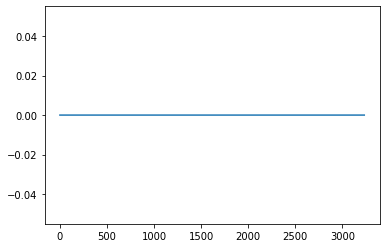

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

env_val = TradingEnv(data.iloc[train:], 78, 105)
state = env_val.reset()
profit = []
done = False
while done != True:
    action = np.argmax(Q[state]) #1
    state, reward, done, info = env_val.step(action) #2

    profit.append(reward)

cum_profit = np.array(profit).cumsum()

plt.plot(cum_profit)
plt.show()

In [ ]:
#Q - Q.mean(axis = 1)

from sklearn.preprocessing import scale
qs = scale(Q - Q.mean(axis = 1, keepdims = 1), axis =1).round(2)

df = pd.DataFrame(qs)
df.columns= ['hold', 'buy_1', 'buy_2', 'sell_1', 'sell_2']

ind = [-np.inf] + np.round(env.bins * 100).astype(int).tolist()
df.index = ind
df.apply(lambda x: df.columns[np.argmax(x)], axis =1)
Q.round()

In [ ]:
num_episodes = 10
steps_total = []
rewards_total = []
egreedy_total = []
# PARAMS 

# Discount on reward
gamma = 0.95

# Factor to balance the ratio of action taken based on past experience to current situtation
learning_rate = 0.5

# exploit vs explore to find action
# Start with 70% random actions to explore the environment
# And with time, using decay to shift to more optimal actions learned from experience

egreedy = 0.7
egreedy_final = 0.1
egreedy_decay = 0.999
Q = torch.zeros([number_of_states, number_of_actions])

In [ ]:
def argmax(arr):
    return torch.max(arr, 0)[1]
    
for i_episode in range(num_episodes):
    
    # resets the environment
    state = env.reset()
    step = 0

    while True:
        
        step += 1
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > egreedy:      
            random_values = Q[state]    
            action = argmax(random_values) 
            action = action_space[action.item()]
        else:
            action = env.action_space.sample()
        
        if egreedy > egreedy_final:
            egreedy *= egreedy_decay
        
        new_state, reward, done, info = env.step(action)

        # Filling the Q Table
        Q[state, action] += learning_rate*(reward + gamma * torch.max(Q[new_state]) - Q[state,action])
        
        # Setting new state for next action
        state = new_state
        
        # env.render()
        # time.sleep(0.4)
        
        if done:
            steps_total.append(step)
            rewards_total.append(reward)
            egreedy_total.append(egreedy)
            if i_episode % 10 == 0:
                print('Episode: {} Reward: {} Steps Taken: {}'.format(i_episode,reward, step))
            break

In [ ]:
Q.round(1)

## Simple Q-learning